# MAPPING AND CLUSTERING CRIMINAL SEXUAL ASSAULTS IN CHICAGO
## EXPLORING CRIME PATTERNS WITH GEOSPATIAL ANALYSIS AND MACHINE LEARNING MODEL (DBSCAN)

In this project, I studied Criminal Sexual Assault incidents in Chicago by looking at their locations on the map. I used geospatial tools to create maps that show where these incidents happened. A machine learning method called DBSCAN is applied to find areas with higher crime density. This helped in identifying high-risk spots and understanding the patterns of these crimes better.

Data Source: Kaggle
https://www.kaggle.com/datasets/currie32/crimes-in-chicago

GIS Shape File: Chicago Data Portal
https://data.cityofchicago.org/Public-Safety/Boundaries-Police-Districts-current-/fthy-xz3r

### Initial Data Exploration
The project begins with Chicago crime data from Kaggle, focusing only on cases of "Criminal Sexual Assault". I cleaned up the data by removing any missing values to make  the analysis accurate. To make the maps more meaningful, I used a shape file, showing the boundaries of Chicago's districts. This file was retrieved from the Chicago Data Portal and helped in adding more detail to the analysis.

In [1]:
# Import Necessary Libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Hide Warning Messages
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
# Load Crime Dataset
df = pd.read_csv('/kaggle/input/crimes-in-chicago/Chicago_Crimes_2012_to_2017.csv')

# Load Chicago District Boundaries (GeoDataset)
gdf = gpd.read_file('/kaggle/input/chicago-dist-boundary/chicagodist_shapefile/poldist.shp')

In [3]:
# Subsetting the Dataset with Criminal Sexual Assault Cases
values = ['CRIM SEXUAL ASSAULT']
df = df[df['Primary Type'].isin(values)]
df.shape

(6823, 23)

In [4]:
# Check Missing Values
df.isna().sum()

Unnamed: 0                0
ID                        0
Case Number               0
Date                      0
Block                     0
IUCR                      0
Primary Type              0
Description               0
Location Description      0
Arrest                    0
Domestic                  0
Beat                      0
District                  0
Ward                      0
Community Area            0
FBI Code                  0
X Coordinate            525
Y Coordinate            525
Year                      0
Updated On                0
Latitude                525
Longitude               525
Location                525
dtype: int64

In [5]:
# Drop Missing Values
df.dropna(inplace=True)
df.shape

(6298, 23)

In [6]:
df.dtypes

Unnamed: 0                int64
ID                        int64
Case Number              object
Date                     object
Block                    object
IUCR                     object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
Beat                      int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                 object
X Coordinate            float64
Y Coordinate            float64
Year                      int64
Updated On               object
Latitude                float64
Longitude               float64
Location                 object
dtype: object

In [7]:
df[['Case Number', 'Date', 'Description', 'Location Description', 'Primary Type', 'Arrest', 'Domestic', 'Year', 'Latitude', 'Longitude']].head(3)

Case Number                    Date        Description  \
138    HZ250880  05/04/2016 08:00:00 AM  AGGRAVATED: OTHER   
191    HY469211  01/01/2015 12:00:00 AM          PREDATORY   
263    HZ250597  05/04/2016 04:40:00 AM     NON-AGGRAVATED   

    Location Description         Primary Type  Arrest  Domestic  Year  \
138                OTHER  CRIM SEXUAL ASSAULT   False     False  2016   
191            RESIDENCE  CRIM SEXUAL ASSAULT    True      True  2015   
263            APARTMENT  CRIM SEXUAL ASSAULT   False     False  2016   

      Latitude  Longitude  
138  41.871567 -87.670488  
191  41.936539 -87.781987  
263  41.877962 -87.726816

In [8]:
gdf.head(3)

DISTNO        DISTNAME                                           geometry
0     OH          O'Hare  POLYGON ((-87.86520 41.97310, -87.86660 41.973...
1     16  Jefferson Park  POLYGON ((-87.86040 41.97650, -87.85820 41.978...
2     17     Albany Park  POLYGON ((-87.74671 41.93860, -87.74803 41.997...

> The dataset, with 6823 rows and 23 columns, was filtered for Criminal Sexual Assault cases. Missing values were removed, and a GIS shapefile with Chicago district boundaries was added for mapping and analysis.

### Geospatial Setup
The crime data was turned into a GeoDataFrame to show each incident as a point on the map. A library called Contextily was used to add basemaps, that give more context to the data. Both the datset were reprojected to the same map format, EPSG:3857. This step made the data ready for accurate mapping and analysis.

In [11]:
# Spatial Distribution Setup
from shapely.geometry import Point
import contextily as ctx
import matplotlib.patches as mpatches

In [12]:
# Convert into GeoDataframe
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
crimes = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Projection
crimes = crimes.to_crs(epsg=3857)
dist = gdf.to_crs(epsg=3857)

In [13]:
crimes.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
dist.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Spatial Distribution of Criminal Sexual Assaults in Chicago
The spatial distribution of Criminal Sexual Assault cases was visualized on a map of Chicago. District boundaries were overlaid with crime locations, and a basemap was added for additional context. This visualization provided a clear overview of where these incidents occurred across the city.

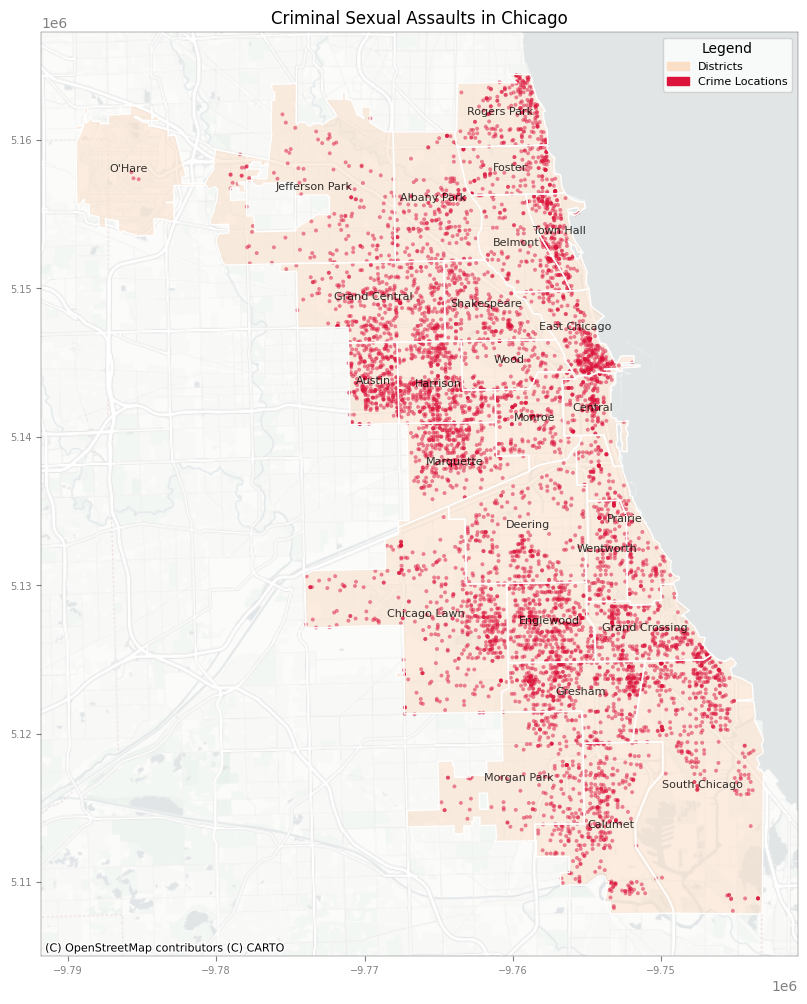

In [15]:
# Crime Distribution on Map

fig, ax = plt.subplots(figsize=(12, 12))
dist.plot(ax=ax, color='#fbdec6', alpha=0.5, label='District Boundary')
crimes.plot(ax=ax, marker='o', color='crimson', edgecolor='none', markersize=8, alpha=0.5, label='Crime Locations')
dist.plot(ax=ax, color='none', edgecolor='white', linewidth=1)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, alpha=0.7)
ax.tick_params(labelsize=7, colors='grey')
for spine in ax.spines.values():
    spine.set_linewidth(0.2)

# Add Labels
for idx, row in dist.iterrows():
    plt.annotate(
        text=row['DISTNAME'],
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        ha='center', fontsize=8, color='black', alpha=0.8
    )

# Add Legend
district_patch = mpatches.Patch(color='#fbdec6', label='Districts')
crime_patch = mpatches.Patch(color='crimson', label='Crime Locations')
plt.legend(handles=[district_patch, crime_patch], loc='upper right', fontsize=8, title='Legend')

plt.title("Criminal Sexual Assaults in Chicago")
plt.show()

> The map shows that incidents are not spread evenly across Chicago. Some districts, especially in the central and southern parts of the city, have clusters where more incidents happen compared to other areas.

### Domestic vs Non-Domestic Crimes
Criminal Sexual Assault cases were categorized into domestic and non-domestic groups. Each category is shown with different colors on the map to effectively compare the distribution patterns of domestic and non-domestic incidents across Chicago.

In [16]:
# Split crime points into domestic and non-domestic
domestic = crimes[crimes['Domestic'] == True]
non_domestic = crimes[crimes['Domestic'] == False]

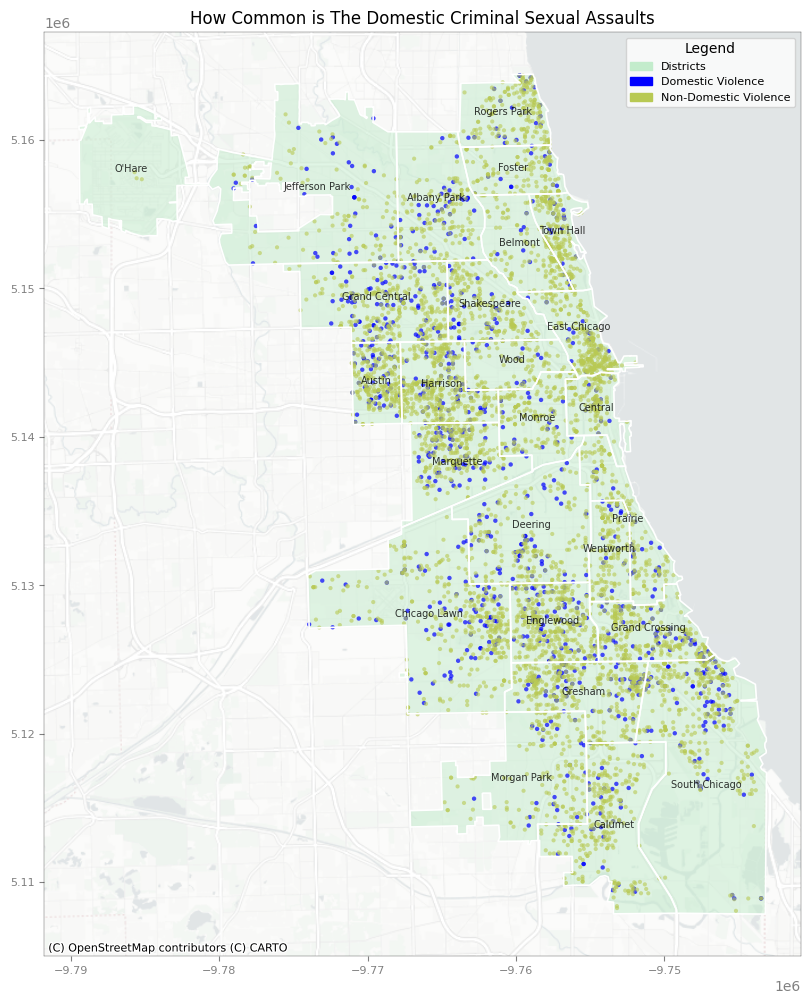

In [17]:
# Domestic and Non-Domestic Crimes on Map

fig, ax = plt.subplots(figsize=(12, 12))

dist.plot(ax=ax, color='#c3eccc', alpha=0.5, label='District Boundary')
domestic.plot(ax=ax, marker='o', color='blue', edgecolor='none', markersize=10, alpha=0.7, label='Domestic Violence')
non_domestic.plot(ax=ax, marker='o', color='#b8c953', edgecolor='none', markersize=9, alpha=0.6, label='Non-Domestic Violence')
dist.plot(ax=ax, color='none', edgecolor='white', linewidth=1.2)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, alpha=0.7)
ax.tick_params(labelsize=8, colors='grey')
for spine in ax.spines.values():
    spine.set_linewidth(0.2)
#ax.set_axis_off()

# Add Labels
for idx, row in dist.iterrows():
    plt.annotate(
        text=row['DISTNAME'],
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        ha='center', fontsize=7, color='black', alpha=0.8
    )

# Add Legend
district_patch = mpatches.Patch(color='#c3eccc', label='Districts')
domestic_patch = mpatches.Patch(color='blue', label='Domestic Violence')
non_domestic_patch = mpatches.Patch(color='#b8c953', label='Non-Domestic Violence')
plt.legend(handles=[district_patch,domestic_patch,non_domestic_patch], loc='upper right', fontsize=8, title='Legend')

plt.title("How Common is The Domestic Criminal Sexual Assaults")
plt.show()

> The map highlights that domestic violence cases are much fewer than non-domestic cases. Domestic incidents tend to be concentrated in specific neighborhoods, particularly in the central and southern parts of the city. On the other hand, non-domestic cases are spread more evenly across Chicago, covering a broader area. This difference in distribution shows the distinct patterns and factors influencing domestic versus non-domestic incidents.

### Arrest vs Non-Arrest Cases
Criminal Sexual Assault cases were also categorized based on whether an arrest was made or not. Arrests and non-arrests were shown in different colors on the map to make their distribution easy to see.

In [18]:
# Arrest and non-arrest
arrest = crimes[crimes['Arrest'] == True]
non_arrest = crimes[crimes['Arrest'] == False]

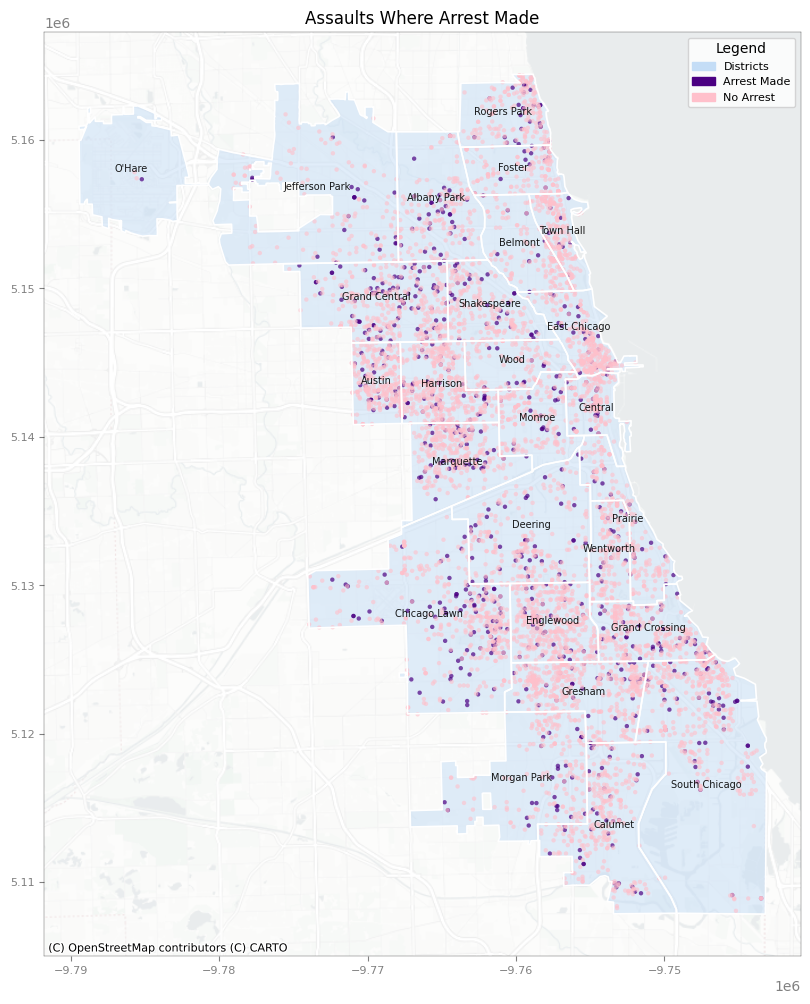

In [19]:
# Arrest and Non-Arrest Crimes on Map

fig, ax = plt.subplots(figsize=(12, 12))

dist.plot(ax=ax, color='#c4ddf6', alpha=0.5, label='District Boundary')
arrest.plot(ax=ax, marker='o', color='indigo', edgecolor='none', markersize=10, alpha=0.7, label='Domestic Violence')
non_arrest.plot(ax=ax, marker='o', color='pink', edgecolor='none', markersize=10, alpha=0.6, label='Non-Domestic Violence')
dist.plot(ax=ax, color='none', edgecolor='white', linewidth=1.2)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, alpha=0.5)
ax.tick_params(labelsize=8, colors='grey')
for spine in ax.spines.values():
    spine.set_linewidth(0.2)
#ax.set_axis_off()

# Add Labels
for idx, row in dist.iterrows():
    plt.annotate(
        text=row['DISTNAME'],
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        ha='center', fontsize=7, color='black', alpha=0.9
    )

# Add Legend
district_patch = mpatches.Patch(color='#c4ddf6', label='Districts')
domestic_patch = mpatches.Patch(color='indigo', label='Arrest Made')
non_domestic_patch = mpatches.Patch(color='pink', label='No Arrest')
plt.legend(handles=[district_patch,domestic_patch,non_domestic_patch], loc='upper right', fontsize=8, title='Legend')

plt.title("Assaults Where Arrest Made")
plt.show()

The map reveals that arrests are much fewer than non-arrest cases. Arrests tend to form clusters in specific areas, while non-arrest cases are spread more evenly across the city. This difference shows that making arrests in such cases is challenging and varies across neighborhoods. The limited number of arrests compared to total cases may also highlight enforcement difficulties or differences in how cases are resolved.

### Crimes in Each District of Chicago
The number of crimes in each district was calculated by combining the crime data with district boundaries. This information was displayed on a choropleth map, where each district is shaded based on the number of incidents.

In [20]:
# Spatial Join Between Two Dataframe
distcounts = gpd.sjoin(crimes, dist, how="inner", op="within")

# Group by District and Count Incidents
crimecounts = distcounts.groupby("DISTNAME").size()
dist["crime_count"] = dist["DISTNAME"].map(crimecounts).fillna(0).astype(int)

In [21]:
import matplotlib as mpl

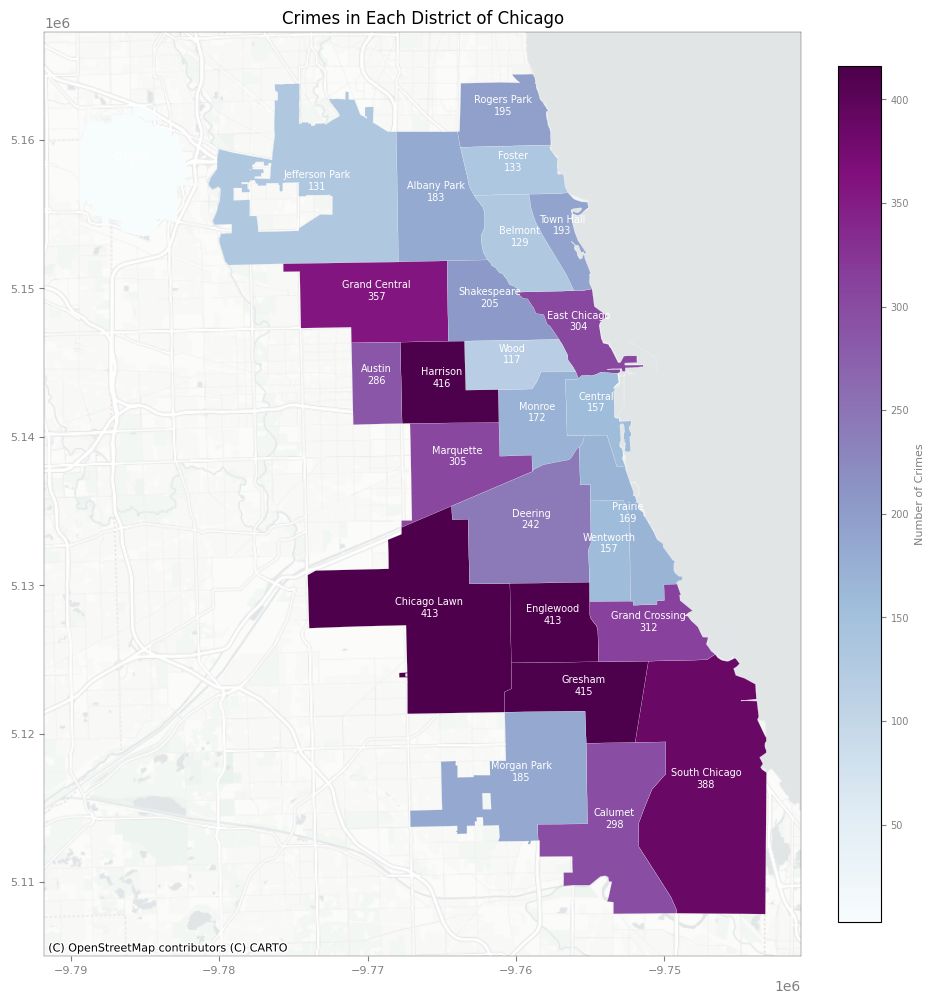

In [22]:
# Plot the Choropleth Map Based on Crimes

fig, ax = plt.subplots(figsize=(12, 12))
dist.plot(ax=ax, column='crime_count', cmap='BuPu', alpha=1, edgecolor='white', linewidth=0.1, legend=False,
             legend_kwds={'label': "Number of Crimes",'orientation': "horizontal"})

# Add Labels
for idx, row in dist.iterrows():
    plt.annotate(
        text=f"{row['DISTNAME']}\n{row['crime_count']}",
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        ha='center', fontsize=7, color='white'
    )

# Add a Colorbar (Custom Legend)
norm = mpl.colors.Normalize(vmin=dist['crime_count'].min(), vmax=dist['crime_count'].max())
sm = mpl.cm.ScalarMappable(cmap='BuPu', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Number of Crimes', fontsize=8, color='grey')
cbar.ax.tick_params(labelsize=7, colors='grey')

# Base Map
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, alpha=0.7)

# Ticks and Frame
ax.tick_params(labelsize=8, colors='grey')
for spine in ax.spines.values():
    spine.set_linewidth(0.2)

plt.title("Crimes in Each District of Chicago")
plt.show()

> The map shows that some districts, like Harrison, Gresham, Chicago Lawn, and Englewood, have higher crime numbers, while others, like Belmont and Jefferson Park, report fewer incidents. This variation could be due to differences in population density, local law enforcement efforts, or other regional factors that influence crime rates.

### Crime Rates per Square Kilometer
To better understand crime density, the number of crimes in each district was divided by the district's area to calculate the crime rate per square kilometer. This data was visualized on a choropleth map, making it easy to compare crime intensity across different districts.

In [23]:
# Calculated in Square Kilometers
dist['area_sqkm'] = dist.geometry.area / 1e6  # Convert to square kilometers

# Calculate crime rate per square kilometer
dist['crime_rate_per_sqkm'] = (dist['crime_count'] / dist['area_sqkm']).round().astype(int)

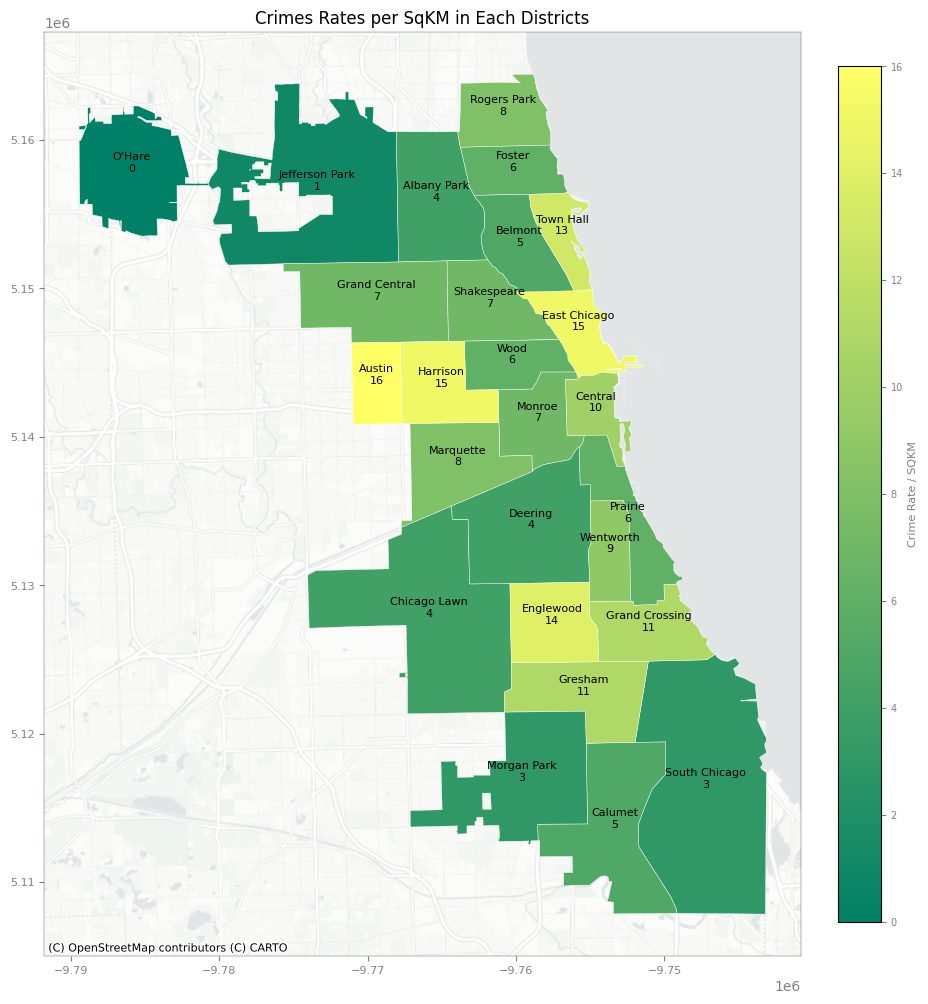

In [24]:
# Crime Rates per Sq/km
fig, ax = plt.subplots(figsize=(12, 12))
dist.plot(ax=ax, column='crime_rate_per_sqkm', cmap='summer', alpha=1, edgecolor='white', linewidth=0.3, legend=False)

# Add Labels
for idx, row in dist.iterrows():
    plt.annotate(
        text=f"{row['DISTNAME']}\n{row['crime_rate_per_sqkm']}",
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        ha='center', fontsize=8, color='black'
    )

# Add a Colorbar (Custom Legend)
norm = mpl.colors.Normalize(vmin=dist['crime_rate_per_sqkm'].min(), vmax=dist['crime_rate_per_sqkm'].max())
sm = mpl.cm.ScalarMappable(cmap='summer', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Crime Rate / SQKM', fontsize=8, color='grey')
cbar.ax.tick_params(labelsize=7, colors='grey')

# Base Map
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, alpha=0.7)

# Ticks and Frame
ax.tick_params(labelsize=8, colors='grey')
for spine in ax.spines.values():
    spine.set_linewidth(0.2)

plt.title("Crimes Rates per SqKM in Each Districts")
plt.show()

> The map shows clear differences in crime rates when adjusted for the size of each district. Districts like Austin, East Chicago and Harrison have much higher crime rates per square kilometer, highlighting their higher intensity of incidents. In contrast, larger districts such as O'Hare and Jefferson Park have significantly lower crime density. This comparison helps to understand crime patterns more accurately by taking district size into account.

### Crime Heatmap Using KDE
A heatmap was created using Kernel Density Estimation (KDE) to show areas with higher concentrations of crimes across Chicago. This method provides a smooth and clear visualization of where crimes are more frequent.

In [25]:
from scipy.stats import gaussian_kde

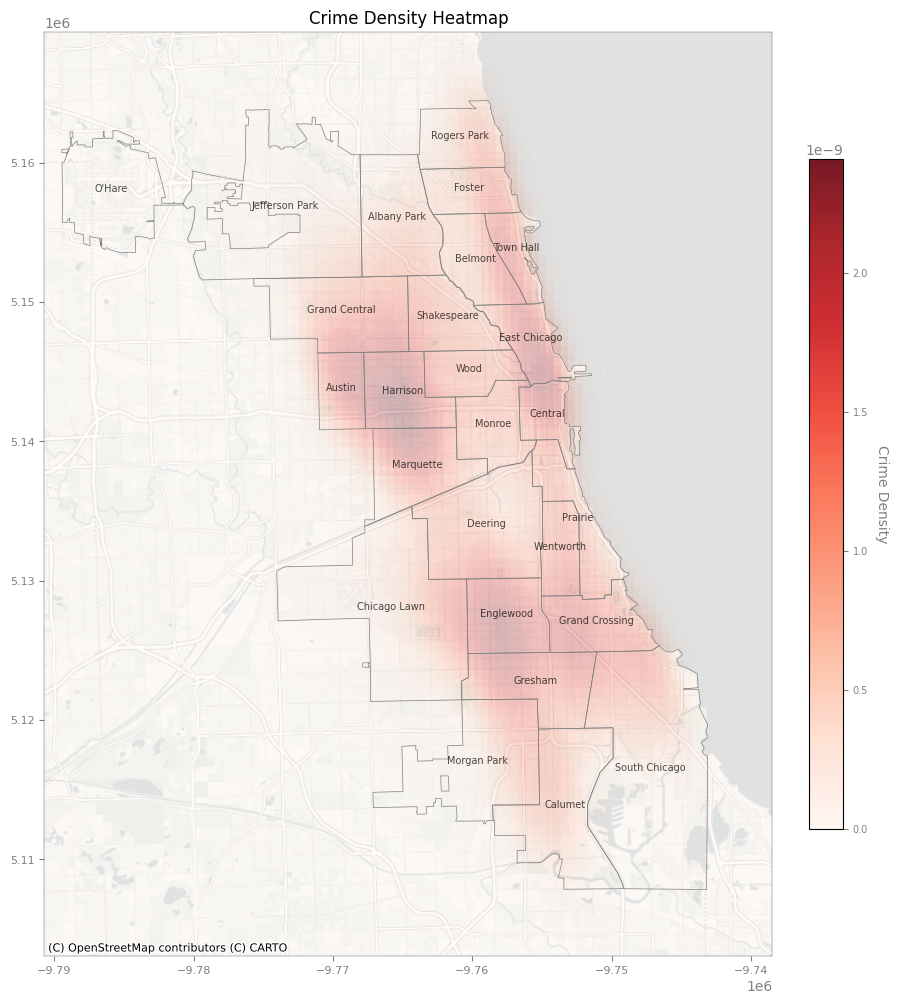

In [26]:
# Perform KDE

coords = np.vstack([crimes.geometry.x, crimes.geometry.y])

kde = gaussian_kde(coords)

buffer = 5000
xmin, xmax = coords[0].min() - buffer, coords[0].max() + buffer
ymin, ymax = coords[1].min() - buffer, coords[1].max() + buffer

# Generate KDE grid
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kde(positions).T, X.shape)

# Plot KDE heatmap
fig, ax = plt.subplots(figsize=(12, 12))
heatmap = ax.imshow(np.rot90(Z), cmap='Reds', extent=[xmin, xmax, ymin, ymax], alpha=0.9)

dist.plot(ax=ax, facecolor='none', edgecolor='grey', linewidth=0.5)
for idx, row in dist.iterrows():
    plt.annotate(
        text=row['DISTNAME'],
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        ha='center', fontsize=7, color='black', alpha=0.7
    )

ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, alpha=0.7)
ax.tick_params(labelsize=8, colors='grey')
for spine in ax.spines.values():
    spine.set_linewidth(0.2)

# Add color bar
cbar = plt.colorbar(heatmap, ax=ax, orientation='vertical', fraction=0.036, pad=0.04)
cbar.set_label('Crime Density', rotation=270, labelpad=15, color='grey')
cbar.ax.tick_params(labelsize=7, colors='grey')

ax.set_title("Crime Density Heatmap")
plt.show()

> The KDE heatmap highlights areas with a higher number of crimes, particularly in central and southern districts like Harrison and Englewood. This smoothed representation makes it easier to spot potential crime hotspots and understand how incidents are distributed across the city.

### Insights from Spatial Analysis
Criminal Sexual Assault cases are not spread evenly across Chicago. Central and southern districts, like Harrison and Englewood, have more incidents compared to other areas. Domestic violence cases are fewer and tend to cluster in specific neighborhoods, while non-domestic cases are spread more evenly across the city. Arrests are much less common than non-arrest cases and often form clusters in certain areas. Non-arrest cases are more evenly distributed.  
Some districts, such as Harrison, Chicago Lawn, and Englewood, report the highest number of incidents, while areas like Belmont and Jefferson Park show much lower crime counts. When adjusted for district size, Austin and Harrison have the highest crime rates per square kilometer, showing intense activity even in smaller physical areas. The KDE heatmap further highlights hotspots in central and southern regions, providing a clear view of where crime is most concentrated.

### Spatio-Temporal Clustering Using DBSCAN
A machine learning method called DBSCAN (Density-Based Spatial Clustering of Applications with Noise) was used to find groups of crimes that occurred close together in both location and time. The data included spatial coordinates and timestamps, which were adjusted to make the analysis consistent. This approach helped in spotting both clusters and isolated points.

In [27]:
# Import DBSCAN Model
from sklearn.cluster import DBSCAN

# Convert into Date Format
crimes['Date'] = pd.to_datetime(crimes['Date'])

# Convert 'Date' to numeric timestamp (seconds since epoch)
crimes['timestamp'] = crimes['Date'].view('int64') // 10**9

# Extract spatial and temporal features
coords = np.array(list(zip(crimes.geometry.x, crimes.geometry.y)))  # Spatial features
timestamps = crimes['timestamp'].values.reshape(-1, 1)  # Temporal features

# Combine spatial and temporal features
features = np.hstack((coords, timestamps))

# Normalize the features to balance spatial and temporal scales
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Define parameters for DBSCAN
eps = 0.05
min_samples = 11

# Fit DBSCAN Model
db = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
crimes['cluster'] = db.fit_predict(features_scaled)

# Show Model Results
num_clusters = len(set(crimes['cluster'])) - (1 if -1 in crimes['cluster'] else 0)
print(f"Number of spatio-temporal clusters found: {num_clusters}")
print(f"Number of noise points: {(crimes['cluster'] == -1).sum()}")

Number of spatio-temporal clusters found: 17
Number of noise points: 993


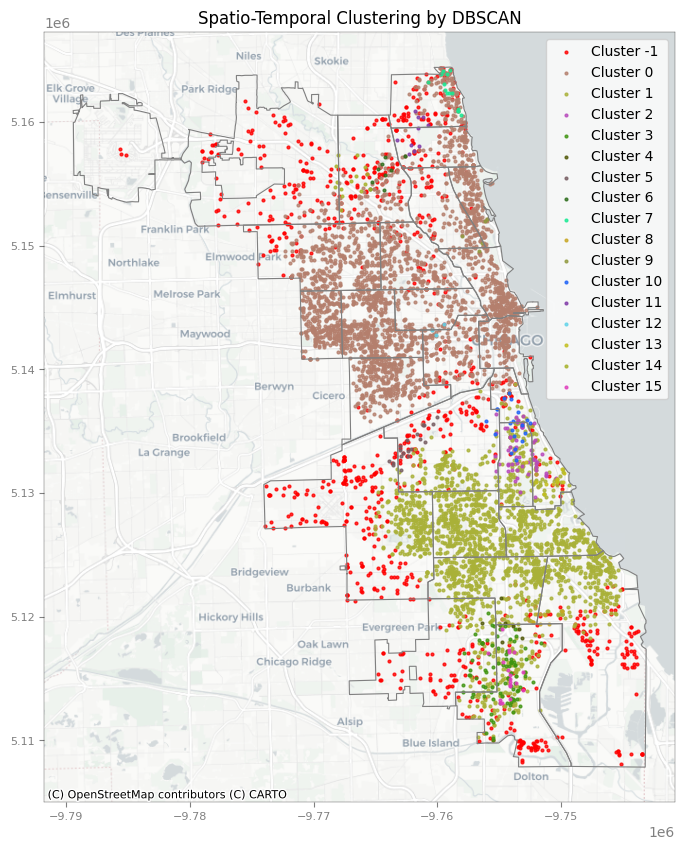

In [28]:
# Plot Clusters

fig, ax = plt.subplots(figsize=(10, 10))

for cluster_id in sorted(crimes['cluster'].unique()):
    cluster_data = crimes[crimes['cluster'] == cluster_id]
    color = 'red' if cluster_id == -1 else np.random.rand(3,)  # Red for outliers
    cluster_data.plot(ax=ax, color=color, markersize=4, label=f"Cluster {cluster_id}", alpha=0.8)

dist.plot(ax=ax, facecolor='none', edgecolor='grey', linewidth=0.8)
ctx.add_basemap(ax, crs=crimes.crs, source=ctx.providers.CartoDB.Positron)

ax.tick_params(labelsize=8, colors='grey')
for spine in ax.spines.values():
    spine.set_linewidth(0.2)

plt.title("Spatio-Temporal Clustering by DBSCAN")
plt.legend()
plt.show()

In [29]:
cluster_sizes = crimes['cluster'].value_counts()
print(cluster_sizes)

cluster
 0     2837
 1     2184
-1      993
 3       89
 2       56
 10      20
 15      19
 5       19
 14      15
 7       14
 13      12
 11      10
 6        9
 4        7
 8        6
 9        5
 12       3
Name: count, dtype: int64


>The DBSCAN clustering identified 17 clusters and 993 noise points (isolated cases). Two large clusters, Cluster 0 and Cluster 1, included the majority of incidents, with 2837 and 2184 cases, respectively. Smaller clusters, like Clusters 3, 5, and 9, showed patterns in specific areas and times. Cases labeled as Cluster -1 were outliers that didn’t fit into any group. This clustering highlights key areas and periods with high activity, providing insights that could help focus prevention or enforcement efforts.

#### Investigating Major Clusters Characteristics (Cluster 0 and Cluster 1)
The two major clusters, Cluster 0 and Cluster 1, were analyzed further to explore their characteristics. Maps were created to show their locations across Chicago, and trends over the years were compared using line plots. A bar plot was also created to compare crime occurrences in different location types for both clusters.

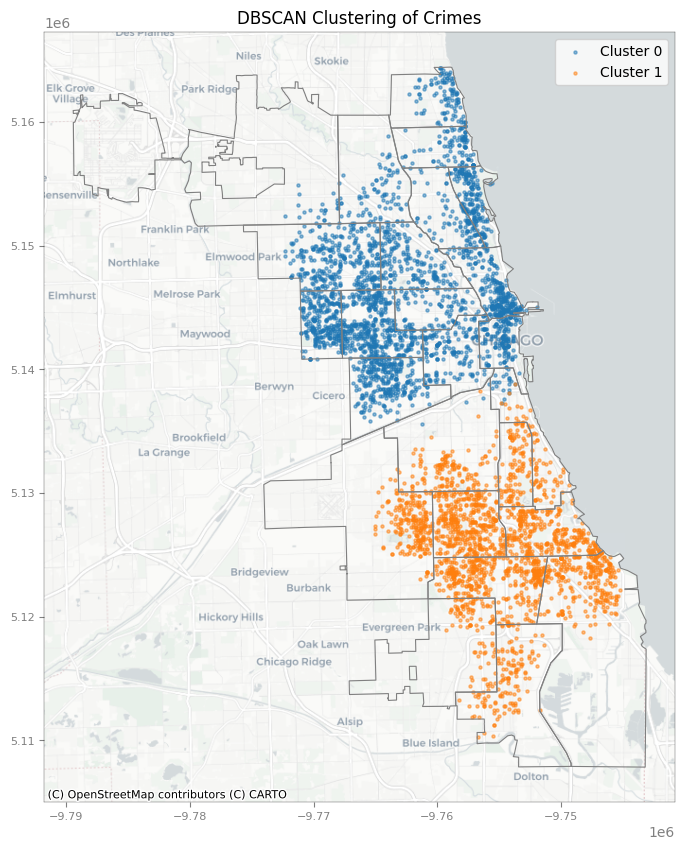

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot clusters
for cluster_id in [0, 1]:  # Investigate the two largest clusters
    cluster_data = crimes[crimes['cluster'] == cluster_id]
    cluster_data.plot(ax=ax, markersize=5, label=f"Cluster {cluster_id}", alpha=0.5)

# Add basemap
dist.plot(ax=ax, facecolor='none', edgecolor='grey', linewidth=0.8)
ctx.add_basemap(ax, crs=crimes.crs, source=ctx.providers.CartoDB.Positron)

ax.tick_params(labelsize=8, colors='grey')
for spine in ax.spines.values():
    spine.set_linewidth(0.2)

# Add title and legend
plt.title("DBSCAN Clustering of Crimes")
plt.legend()
plt.show()

>Cluster 0 is mostly concentrated in northern and central areas, while Cluster 1 is focused on the southern parts of the city. This shows distinct differences in crime distribution between the two clusters.

In [31]:
# Identifying Trends Over the Year
temporal_trends = crimes[crimes['cluster'].isin([0, 1])].groupby(['cluster', crimes['Date'].dt.year]).size()

# Convert to DataFrame for visualization
temporal_trends_df = temporal_trends.reset_index(name='count')
temporal_trends_df.rename(columns={'Date': 'year'}, inplace=True)

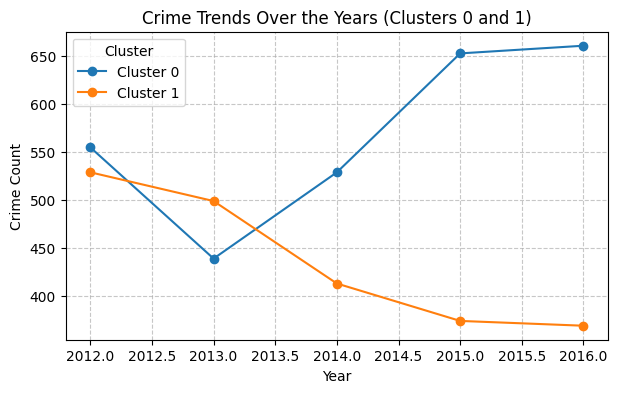

In [32]:
# Plot Yearly Trends for Each Cluster

fig, ax = plt.subplots(figsize=(7, 4))

for cluster_id in [0, 1]:
    cluster_data = temporal_trends_df[temporal_trends_df['cluster'] == cluster_id]
    ax.plot(
        cluster_data['year'], 
        cluster_data['count'], 
        marker='o', 
        label=f"Cluster {cluster_id}"
    )

ax.set_title("Crime Trends Over the Years (Clusters 0 and 1)")
ax.set_xlabel("Year")
ax.set_ylabel("Crime Count")
ax.legend(title="Cluster")
ax.grid(axis='both', linestyle='--', alpha=0.7)

plt.show()

>A yearly comparison reveals that crimes in Cluster 0 have increased from 2012 to 2016, while Cluster 1 shows a decline during the same period. This suggests evolving crime patterns in different areas.

In [33]:
# Identifying Crime Types by Location Distribution

crime_types = crimes[crimes['cluster'].isin([0, 1])].groupby(['cluster', 'Location Description']).size()
crime_types_df = crime_types.reset_index(name='count')
crime_types_pivot = crime_types_df.pivot(index='Location Description', columns='cluster', values='count').fillna(0)

crime_types_pivot['Total'] = crime_types_pivot.sum(axis=1)
top_10_crime_types = crime_types_pivot.nlargest(10, 'Total').drop(columns=['Total'])

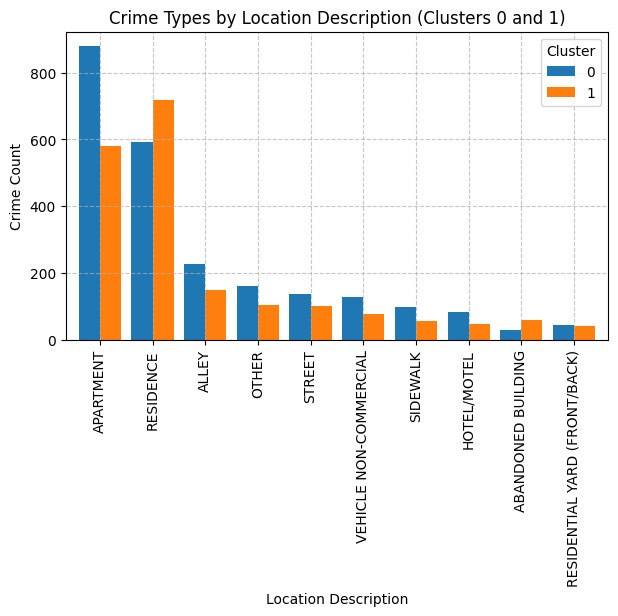

In [34]:
fig, ax = plt.subplots(figsize=(7, 4))
top_10_crime_types.plot(kind='bar', stacked=False, ax=ax, width=0.8)

ax.set_title("Crime Types by Location Description (Clusters 0 and 1)")
ax.set_xlabel("Location Description")
ax.set_ylabel("Crime Count")
ax.legend(title="Cluster")
ax.tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability
ax.grid(axis='both', linestyle='--', alpha=0.7)

plt.show()

>The bar plot shows that "Apartment" locations are the most common for both clusters, followed by "Residence." Cluster 0 has significantly more crimes in apartments, while Cluster 1 shows more incidents in residences. This highlights the importance of these settings for targeted interventions.

### Insights from DBSCAN Clustering
Cluster 0 is concentrated in northern and central Chicago, while Cluster 1 dominates the southern regions. Over time, Cluster 0 has seen an increase in crimes, while Cluster 1 has experienced a decline. "Apartment" locations are prominent in Cluster 0, whereas "Residence" crimes are higher in Cluster 1. These findings highlight differences in geography, timing, and settings, suggesting the need for targeted strategies to address specific crime patterns in each cluster.